# Track an experiment while training a Pytorch model locally or in your notebook

---
## Introductions

This notebook shows how you can use the SageMakerCore SDK to track a Machine Learning experiment using a Pytorch model trained locally.



### Experiment
An experiment is a collection of runs. When you initialize a run in your training loop, you include the name of the experiment that the run belongs to. Experiment names must be unique within your AWS account.

## Pre-Requisites

### Install Latest SageMakerCore
All SageMakerCore beta distributions will be released to a private s3 bucket. After being allowlisted, run the cells below to install the latest version of SageMakerCore from `s3://sagemaker-core-beta-artifacts/sagemaker_core-latest.tar.gz`

Ensure you are using a kernel with python version >=3.8

In [ ]:
# Uninstall previous version of sagemaker_core and restart kernel
!pip uninstall sagemaker_core -y

In [ ]:
# Make dist/ directory to hold the sagemaker_core beta distribution file
!mkdir dist

In [ ]:
# Download and Install the latest version of sagemaker_core
!aws s3 cp s3://sagemaker-core-beta-artifacts/sagemaker_core-latest.tar.gz dist/

!pip install dist/sagemaker_core-latest.tar.gz

In [ ]:
# Check the version of sagemaker_core
!pip show -v sagemaker_core

In [ ]:
### Install Additional Packages

In [2]:
# Install additionall packages

!pip install -U torch torchvision matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 752.4 kB/s eta 0:00:00a 0:00:01
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 27.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.8/260.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 10.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 kB 2.3 MB/s eta 0:00:00
Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


### Setup

Import required libraries and set logging and experiment configuration

In [1]:
from torchvision import datasets, transforms
import torch
import os
import sys
import time
from IPython.display import set_matplotlib_formats
from matplotlib import pyplot as plt
from sagemaker_core.helper.session_helper import get_execution_role, Session

session = Session()
region = session.boto_region_name

experiment_name = "pyspark-experiment-example" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
trial_name = "Default-Run-Group-" + experiment_name

[08/22/24 16:15:40] INFO     INFO:botocore.credentials:Found credentials in shared credentials  ]8;id=721582;file:///Users/pintaoz/.pyenv/versions/py3.10/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=363762;file:///Users/pintaoz/.pyenv/versions/py3.10/lib/python3.10/site-packages/botocore/credentials.py#1278\1278]8;;\
                             file: ~/.aws/credentials                                                              

### Download the dataset

Let's now use the torchvision library to download the MNIST dataset from tensorflow and apply a transformation on each image

In [3]:
# download the dataset
# this will not only download data to ./mnist folder, but also load and transform (normalize) them
datasets.MNIST.urls = [
    f"https://sagemaker-example-files-prod-{region}.s3.amazonaws.com/datasets/image/MNIST/train-images-idx3-ubyte.gz",
    f"https://sagemaker-example-files-prod-{region}.s3.amazonaws.com/datasets/image/MNIST/train-labels-idx1-ubyte.gz",
    f"https://sagemaker-example-files-prod-{region}.s3.amazonaws.com/datasets/image/MNIST/t10k-images-idx3-ubyte.gz",
    f"https://sagemaker-example-files-prod-{region}.s3.amazonaws.com/datasets/image/MNIST/t10k-labels-idx1-ubyte.gz",
]

train_set = datasets.MNIST(
    "mnist_data",
    train=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    ),
    download=True,
)

test_set = datasets.MNIST(
    "mnist_data",
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    ),
    download=True,
)

In [2]:
s3_client = session.s3_client
bucket_name = session.default_bucket()
for f in os.listdir(train_set.raw_folder):
    file_path = train_set.raw_folder + "/" + f
    s3_client.upload_file(file_path, bucket_name, file_path)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 s3_client = session.s3_client                                                                │
│   2 bucket_name = session.default_bucket()                                                       │
│ ❱ 3 for f in os.listdir(train_set.raw_folder):                                                   │
│   4 │   file_path = train_set.raw_folder + "/" + f                                               │
│   5 │   s3_client.upload_file(file_path, bucket_name, file_path)                                 │
│   6                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'train_set' is not defined

View and example image from the dataset

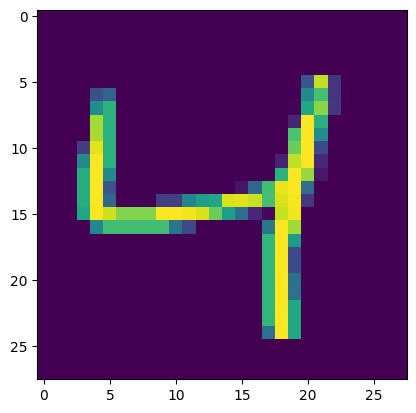

In [3]:
plt.imshow(train_set.data[2].numpy())

### Create experiment and log dataset information

Create an experiment run to track the model training. SageMaker Experiments is a great way to organize your data science work. You can create an experiment to organize all your model runs and analyse the different model metrics with the SageMaker Experiments UI.

Here we create an experiment together with a trial and trial component for it. We also log all the downloaded files as inputs to our model.

In [ ]:
from sagemaker_core.main.resources import Experiment, Trial, TrialComponent
from sagemaker_core.main.shapes import TrialComponentParameterValue, TrialComponentArtifact

# experiment = Experiment.create(experiment_name=experiment_name)
# trial = Trial.create(trial_name=trial_name, experiment_name=experiment_name)

trial_component_parameters = {
    "num_train_samples": TrialComponentParameterValue(number_value=len(train_set.data)), 
    "num_test_samples": TrialComponentParameterValue(number_value=len(test_set.data)),
}
trial_component_input_artifacts = {}
for f in os.listdir(train_set.raw_folder):
    file_path = train_set.raw_folder + "/" + f
    print("Logging", file_path)
    trial_component_input_artifacts[f] = TrialComponentArtifact(value=file_path)

trial_component = TrialComponent.create(
    trial_component_name=experiment_name,
    parameters=trial_component_parameters,
    input_artifacts=trial_component_input_artifacts,
)

### Create model training functions

Create an experiment run to track the model training. SageMaker Experiments is a great way to organize your data science work. You can create an experiment to organize all your model runs and analyse the different model metrics with the SageMaker Experiments UI.

Here we create an experiment run and log parameters for the size of our training and test datasets. We also log all the downloaded files as inputs to our model.

In [6]:
# Based on https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net(torch.nn.Module):
    def __init__(self, hidden_channels, kernel_size, drop_out):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, hidden_channels, kernel_size=kernel_size)
        self.conv2 = torch.nn.Conv2d(hidden_channels, 20, kernel_size=kernel_size)
        self.conv2_drop = torch.nn.Dropout2d(p=drop_out)
        self.fc1 = torch.nn.Linear(320, 50)
        self.fc2 = torch.nn.Linear(50, 10)

    def forward(self, x):
        x = torch.nn.functional.relu(torch.nn.functional.max_pool2d(self.conv1(x), 2))
        x = torch.nn.functional.relu(
            torch.nn.functional.max_pool2d(self.conv2_drop(self.conv2(x)), 2)
        )
        x = x.view(-1, 320)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.nn.functional.log_softmax(x, dim=1)

'mnist_data/MNIST/raw'

In [7]:
experiment

Experiment(experiment_name='pyspark-experiment-example2024-08-22-21-22-49', experiment_arn='arn:aws:sagemaker:us-west-2:058264210671:experiment/pyspark-experiment-example2024-08-22-21-22-49', display_name='pyspark-experiment-example2024-08-22-21-22-49', source=<sagemaker_core.main.utils.Unassigned object at 0x1245cb0d0>, description=<sagemaker_core.main.utils.Unassigned object at 0x1245cb0d0>, creation_time=datetime.datetime(2024, 8, 22, 14, 27, 44, 856000, tzinfo=tzlocal()), created_by=UserContext(user_profile_arn=<sagemaker_core.main.utils.Unassigned object at 0x1245cb0d0>, user_profile_name=<sagemaker_core.main.utils.Unassigned object at 0x1245cb0d0>, domain_id=<sagemaker_core.main.utils.Unassigned object at 0x1245cb0d0>, iam_identity=<sagemaker_core.main.utils.Unassigned object at 0x1245cb0d0>), last_modified_time=datetime.datetime(2024, 8, 22, 14, 27, 44, 856000, tzinfo=tzlocal()), last_modified_by=UserContext(user_profile_arn=<sagemaker_core.main.utils.Unassigned object at 0x1245

In [15]:
bucket_name

'sagemaker-us-west-2-058264210671'